In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ujipenchars2
import string
import random
import itertools
from drawing import Drawing
from preprocessing import DrawingToBoxScaler, DrawingResampler, VideoCreator, GradientCreator, create_gradient
from PIL import Image, ImageDraw, ImageFilter, ImageOps
import tensorly as tl
from tensorly.decomposition import tucker
from IPython.core.display import HTML
from collections import defaultdict
np.random.seed(0)

In [2]:
def circle(draw, center, radius, fill):
    draw.ellipse((center[0] - radius + 1, center[1] - radius + 1, center[0] + radius - 1, center[1] + radius - 1),
                 fill=fill, outline=None)

def remove_duplicate_points(drawing):
    strokes = []
    for stroke in drawing.strokes:
        # Uklanjamo točke koje se ponavljaju više puta zaredom
        unique_mask = np.empty_like(stroke, dtype=np.bool)
        unique_mask[0] = True
        unique_mask[1:] = (stroke[1:] != stroke[:-1])
        unique_mask = np.logical_or.reduce(unique_mask, 1)
        stroke = stroke[unique_mask]
        strokes.append(stroke)
    return Drawing(label=drawing.label, strokes=strokes)

def stroke_times(drawing):
    times = []
    for stroke in drawing.strokes:
        # Računamo vrijeme (duljinu puta) od prve do svake točke
        d = np.diff(stroke, axis=0)
        time = np.empty(stroke.shape[0])
        time[0] = 0
        time[1:] = np.hypot(d[:, 0], d[:, 1]).cumsum()
        times.append(time)
    return times
    
def transform_one(drawing, n):
        video = []
        drawing = remove_duplicate_points(drawing)
        times = stroke_times(drawing)
        stroke_cum_times = np.array([0] + [time[-1] for time in times]).cumsum()
        i = 1
        for frame in range(1, n + 1):
            # Ukupna duljina strokova u frame-u
            last_point_time = (frame / n) * stroke_cum_times[-1]  # > 0
            while True:
                if last_point_time <= stroke_cum_times[i]:
                    break
                i += 1
            # Duljine zadnjeg stroka
            last_point_time -= stroke_cum_times[i - 1]
            time = times[i - 1]
            stroke = drawing.strokes[i - 1]
            time_until_last_point = np.append(time[time < last_point_time], last_point_time)
            last_stroke = np.column_stack((
                np.interp(time_until_last_point, time, stroke[:, 0]).astype(np.float32),
                np.interp(time_until_last_point, time, stroke[:, 1]).astype(np.float32),
            ))
            video.append(Drawing(label=drawing.label, strokes=drawing.strokes[:i - 1] + [last_stroke]))
        return video


def video_to_tensor(video, line_width=10, base_resolution=300, real_resolution=300,blur_radius=3):   
    """pretvara video(listu drawings-a) u numpy.array gdje je svaki slice slika jednog drawing-a"""
    
    #line_width-sirina linije kojom se znamenka crta
    #base_resolution-slika rezolucije base_resolution*base_resolution u kojoj se crta
    #real_resolution-rezolucija na koju se slika skalira na kraju
    #blur_radius-radius zamucivanja
 
    first=True
    for drawing in video:
        scaled_strokes=[stroke*base_resolution for stroke in drawing.strokes]
        img = Image.new("RGB", (base_resolution, base_resolution))
        img1 = ImageDraw.Draw(img)
        for stroke in scaled_strokes:
            x=stroke[:,0]
            y=stroke[:,1]
            y=base_resolution-y-1
            img1.line(np.column_stack((x,y)), width = line_width,fill='white')
            for i in range(len(x)):
                circle(img1, (x[i], y[i]), line_width / 2,'white')
            
            
        gray_image = ImageOps.grayscale(img)
        gray_image=gray_image.filter(ImageFilter.GaussianBlur(radius = blur_radius))
        gray_image=gray_image.resize((real_resolution,real_resolution))
        frontal_slice=np.asarray(gray_image)
        
        if first:
            T=frontal_slice[None]
            first=False
        else:
            T=np.concatenate((T,frontal_slice[None]),axis=0)
    return T


In [3]:
def plot_results(labels, predictions):
    
    df = pd.concat((labels, predictions), axis=1)
    counts = df.groupby(list(df.columns)).size().unstack(fill_value=0)

    images = (
        (counts.div(counts.sum(axis=1), axis=0), 'Raspored znamenaka po predikcijama'), # normaliziramo po retcima
        (counts.div(counts.sum(axis=0)), 'Sastav predviđenih znamenki'), # normaliziramo po stupcima
    )
    plt.figure(figsize=(12, 6))
    for i in range(len(images)):
        plt.subplot(1, 2, i + 1)
        plt.imshow(images[i][0], cmap='Reds', vmin=0, vmax=1, origin='lower')
        plt.title(images[i][1])
        plt.xlabel('Predikcija')
        plt.xticks(range(counts.shape[1]), counts.columns)
        plt.ylabel('Znamenka')
        plt.yticks(range(counts.shape[0]), counts.index)

In [4]:
def accuracy(test_labels,test_predictions):
    print('Točnost je',round(np.sum((np.array(test_labels)==np.array(test_predictions)))/len(test)*100,2),'%.')

In [5]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)
drawing_scaler = DrawingToBoxScaler(0.1,0.9,0.1,0.9)
#drawing_scaler= DrawingToBoxScaler(0,1,0,1)
train = drawing_scaler.transform(train)
test = drawing_scaler.transform(test)

# HOSVD za slike znamenki

In [6]:
n = 20
base=300
n_frames = 5
line_width=45
blur_radius=5
#video_creator = VideoCreator(n=n_frames, clip=(-0.15, 1.15, -0.15, 1.15), size=(20, 20),precision=4)

In [7]:
a=defaultdict(list)
for drawing in train:
    tensor=video_to_tensor(transform_one(drawing,n_frames),base_resolution=base,real_resolution=n,line_width=line_width, 
                           blur_radius=blur_radius)
    #tensor=video_creator.transform_one(drawing)
    a[int(drawing.label)].append(tensor[n_frames-1])
for i in range(10):
    a[i]=np.stack(a[i], axis=0, out=None)
    a[i]=a[i].astype(np.float64)

In [8]:
for i in range(10):
    print(f'len(a[{i}])={len(a[i])}')

len(a[0])=80
len(a[1])=80
len(a[2])=80
len(a[3])=80
len(a[4])=80
len(a[5])=80
len(a[6])=80
len(a[7])=80
len(a[8])=80
len(a[9])=80


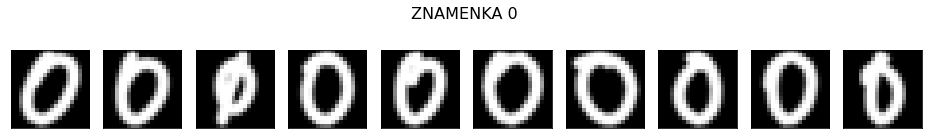

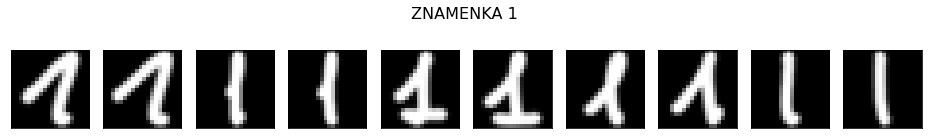

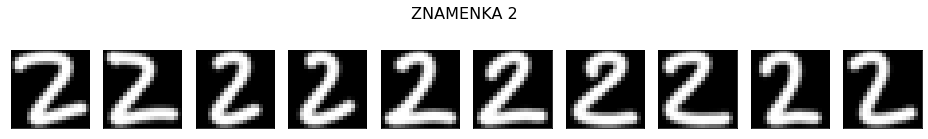

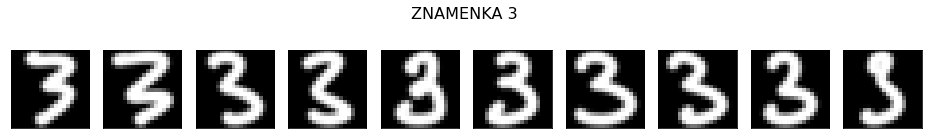

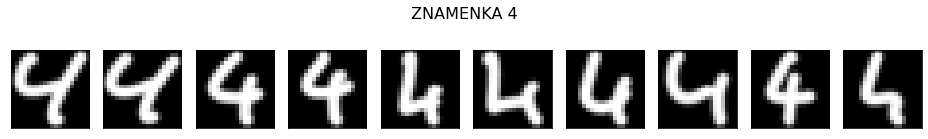

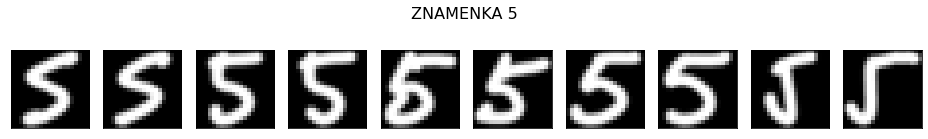

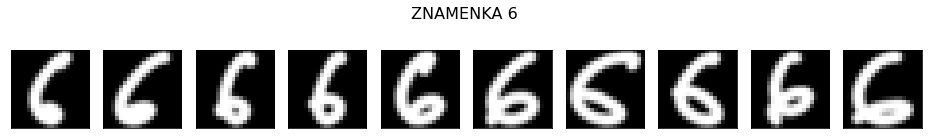

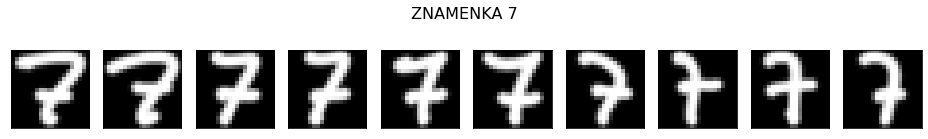

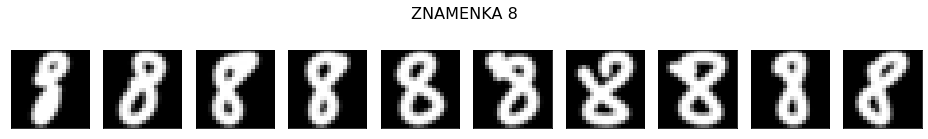

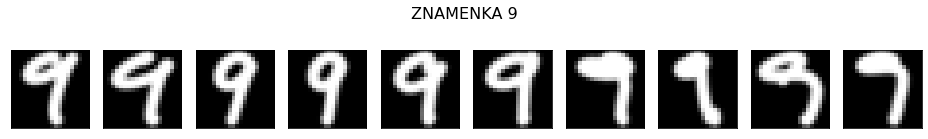

In [9]:
for j in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(a[j][i], cmap='gray', vmin=0, vmax=255)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

Wall time: 1.92 s


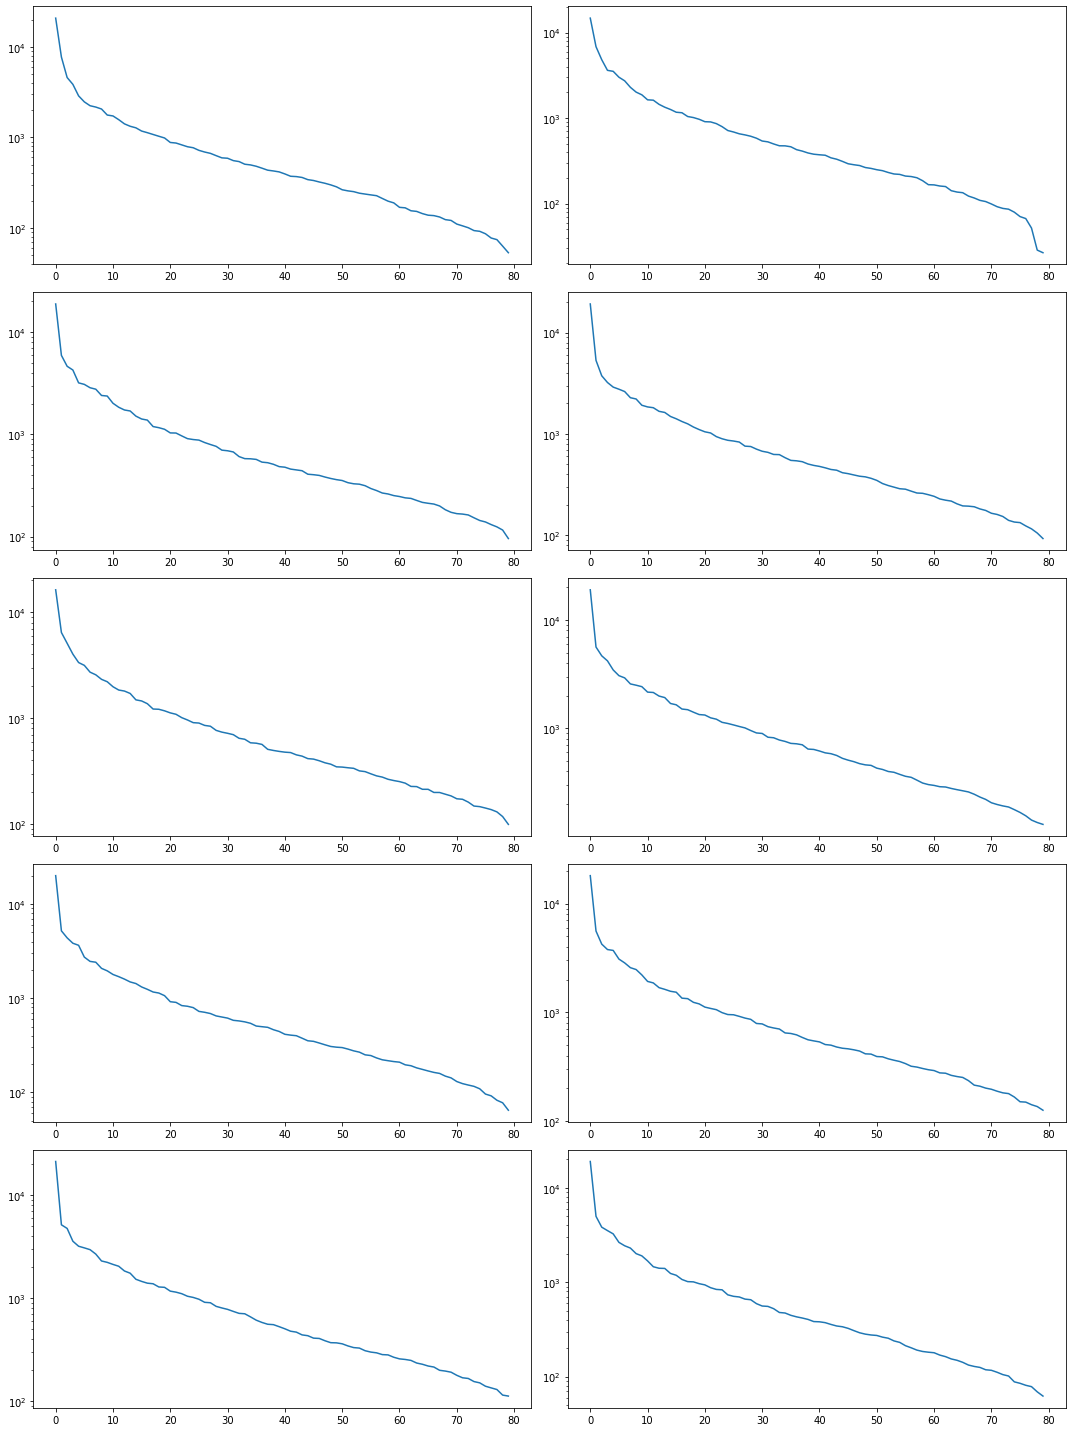

In [10]:
%%time
display(HTML('<h2>Norme odsječaka jezgrenih tenzora u modu 3</h2>'))
core,factors={},{}
m=[]
plt.figure(figsize=(15,20))
for i in range(10):
    a[i]=np.transpose(a[i],axes=[1,2,0])
    third_dim=min(n**2,np.shape(a[i])[2])
    core[i], factors[i] = tucker(a[i],rank=[n,n,third_dim])
    s=[]
    first=1
    for j in range(third_dim):
        s.append(np.linalg.norm(core[i][:,:,j],'fro'))
        if(s[j]<1e-06 and first):
            m.append(j)
            first=0
    if(first==1):
        m.append(third_dim)
        
    plt.subplot(5,2,i+1)
    plt.semilogy(s)
    a[i]=np.transpose(a[i],axes=[2,0,1])
plt.tight_layout()

In [11]:
m

[80, 80, 80, 80, 80, 80, 80, 80, 80, 80]

In [12]:
%%time
S={}
for i in range(10):
    if(m[i]<np.shape(core[i])[2]):
        core[i]=core[i][:,:,:m[i]]
        factors[i][2]=factors[i][2][:,:m[i]]
    S[i]=[]
    for j in range(m[i]):
        s=tl.tenalg.multi_mode_dot(core[i][:,:,j],matrix_or_vec_list=[factors[i][0],factors[i][1]])
        s=s/np.linalg.norm(s,'fro')
        S[i].append(s)

Wall time: 53 ms


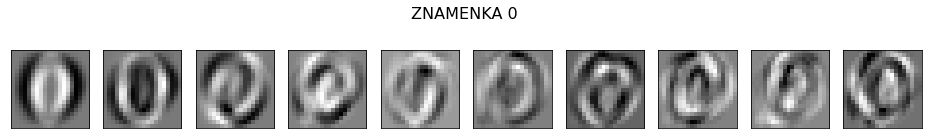

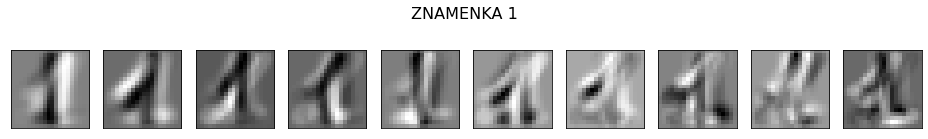

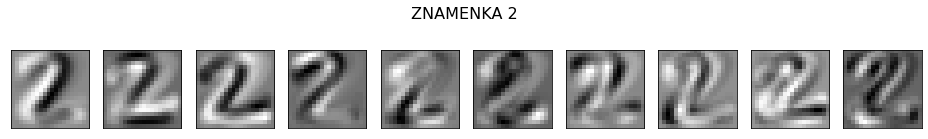

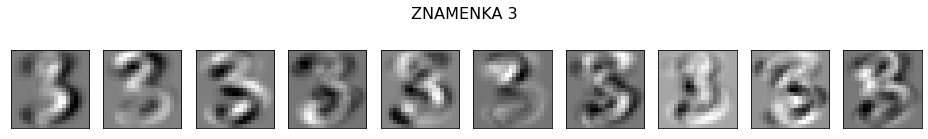

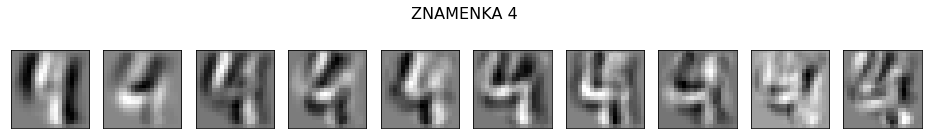

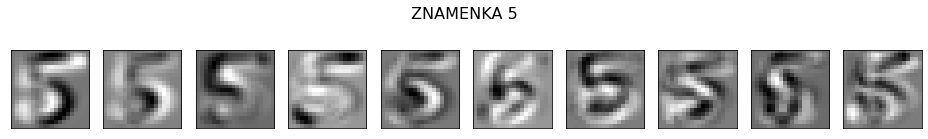

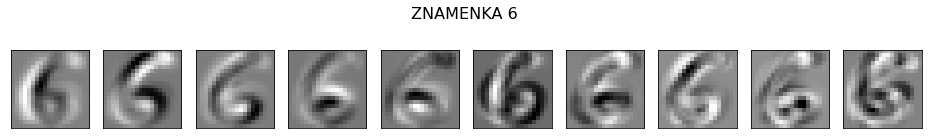

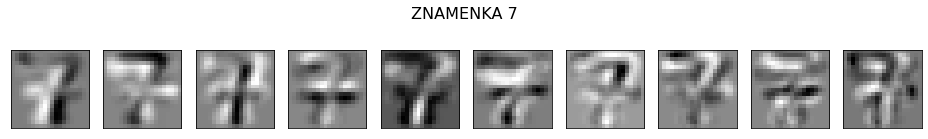

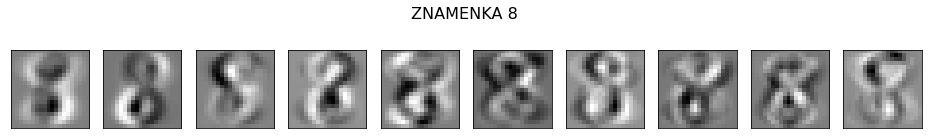

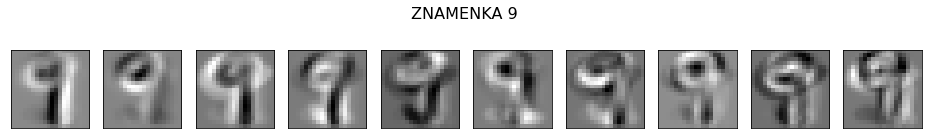

In [13]:
display(HTML('<h2>Komponente tenzorske dekompozicije za svaku znamenku</h2>'))
for j in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(S[j][i+1],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [14]:
%%time
test_predictions=[]
test_labels=[]
T=defaultdict(list)
for drawing in test:
    test_labels.append(int(drawing.label))
    Z=video_to_tensor(transform_one(drawing,n_frames),base_resolution=base,real_resolution=n,line_width=line_width,
                      blur_radius=blur_radius)[n_frames-1]
    #Z=video_creator.transform_one(drawing)[n_frames-1]
    Z=Z.astype(np.float64)
    Z=Z/np.linalg.norm(Z,'fro')
    R=[]
    for j in range(10):
        E=1-sum((np.trace(S[j][k].T @ Z))**2 for k in range(80))
        R.append(E)
    test_predictions.append(np.argmin(R))
    T[np.argmin(R)].append(Z)

Wall time: 7.2 s


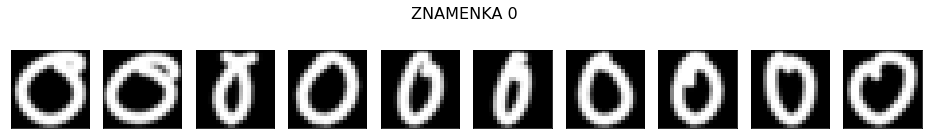

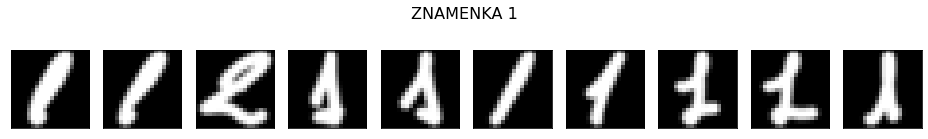

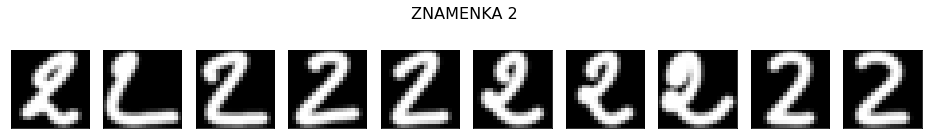

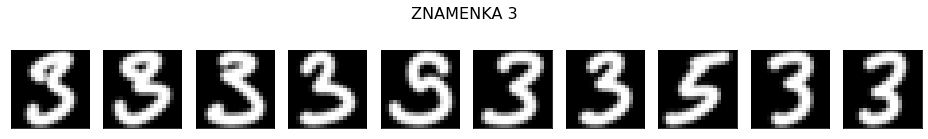

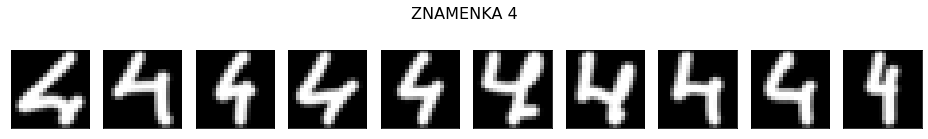

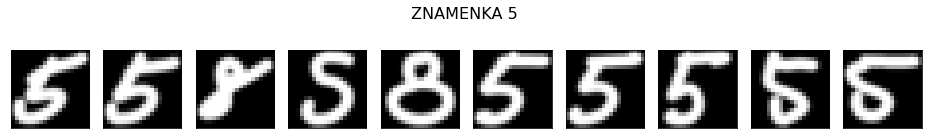

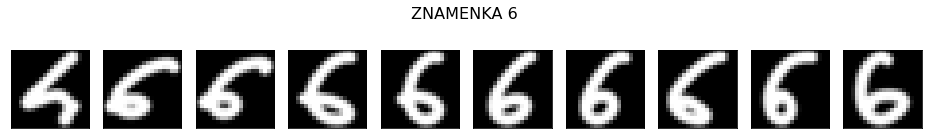

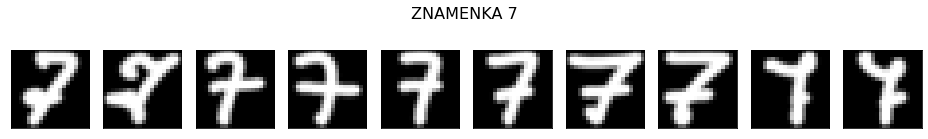

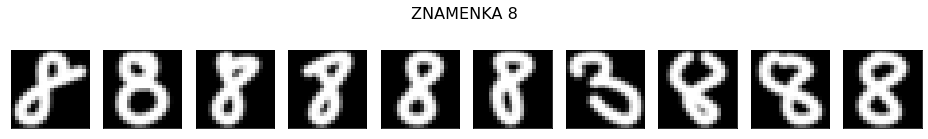

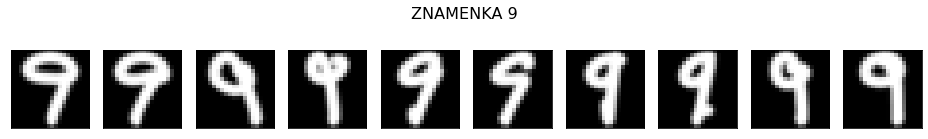

In [15]:
display(HTML('<h2>Predviđene znamenke</h2>'))
for i in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {i}',fontsize=16)
    for j in range(10):
        plt.subplot(1, 10, j + 1)
        plt.imshow(T[i][j],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [16]:
accuracy(test_labels,test_predictions)

Točnost je 93.25 %.


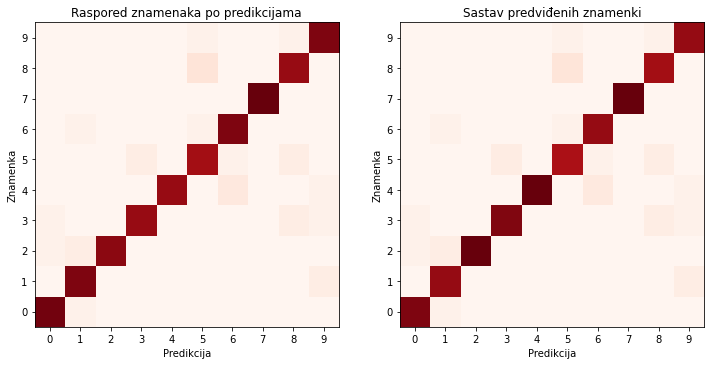

In [17]:
plot_results(pd.Series(test_labels), pd.Series(test_predictions))

# HOSVD za videe znamenki

In [18]:
n = 28
base=300
n_frames = 5
line_width=45
blur_radius=8

In [19]:
A=defaultdict(list)
for drawing in train:
    tensor=video_to_tensor(transform_one(drawing,n_frames),base_resolution=base,real_resolution=n,line_width=line_width,
                           blur_radius=blur_radius)
    A[int(drawing.label)].append(tensor)

for i in range(10):
    for j in range(len(A[i])):
        frames_list=[]
        for k in range(n_frames):
            frames_list.append(A[i][j][k].flatten())
        A[i][j]=np.stack(frames_list, axis=1)
    A[i]=np.stack(A[i], axis=0, out=None)
    A[i]=A[i].astype(np.float64)

In [20]:
np.shape(A[0])

(80, 784, 5)

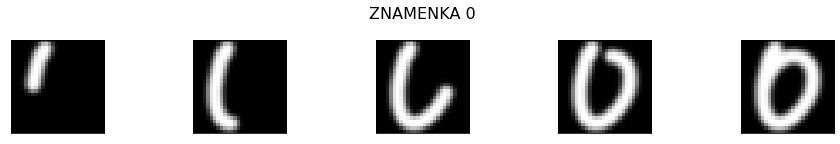

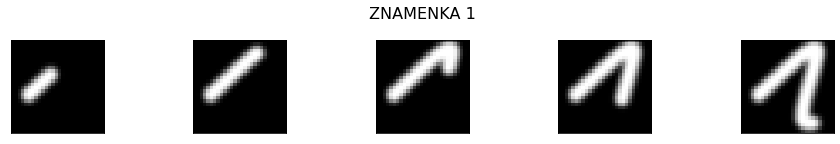

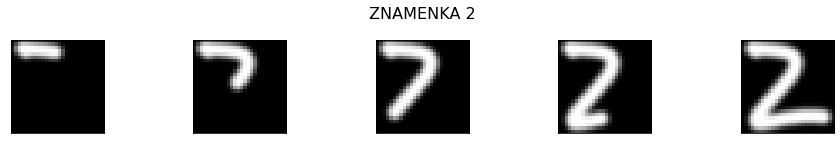

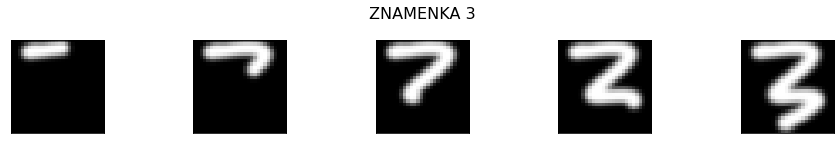

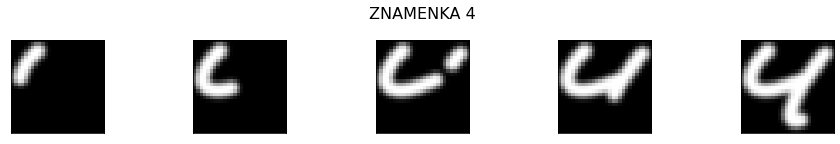

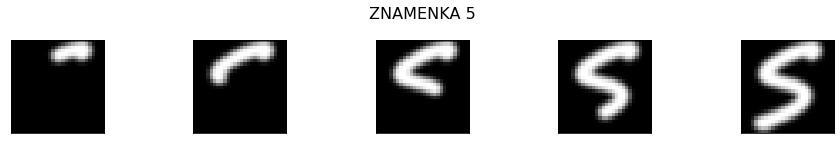

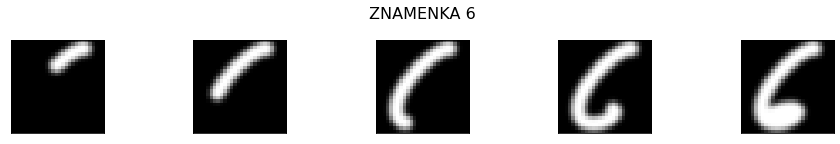

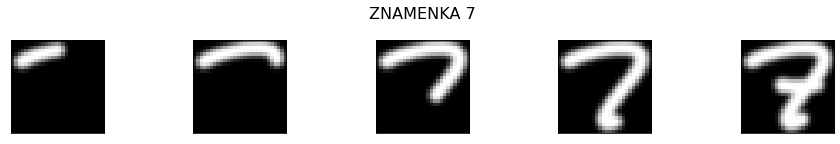

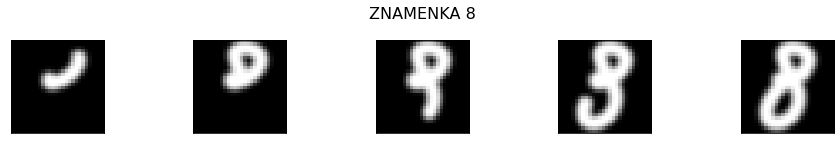

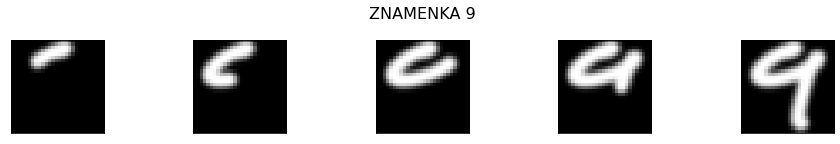

In [21]:
for j in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(n_frames):
        plt.subplot(1, n_frames, i + 1)
        plt.imshow(A[j][1,:,i].reshape(n,n), cmap='gray', vmin=0, vmax=255)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

Wall time: 4.91 s


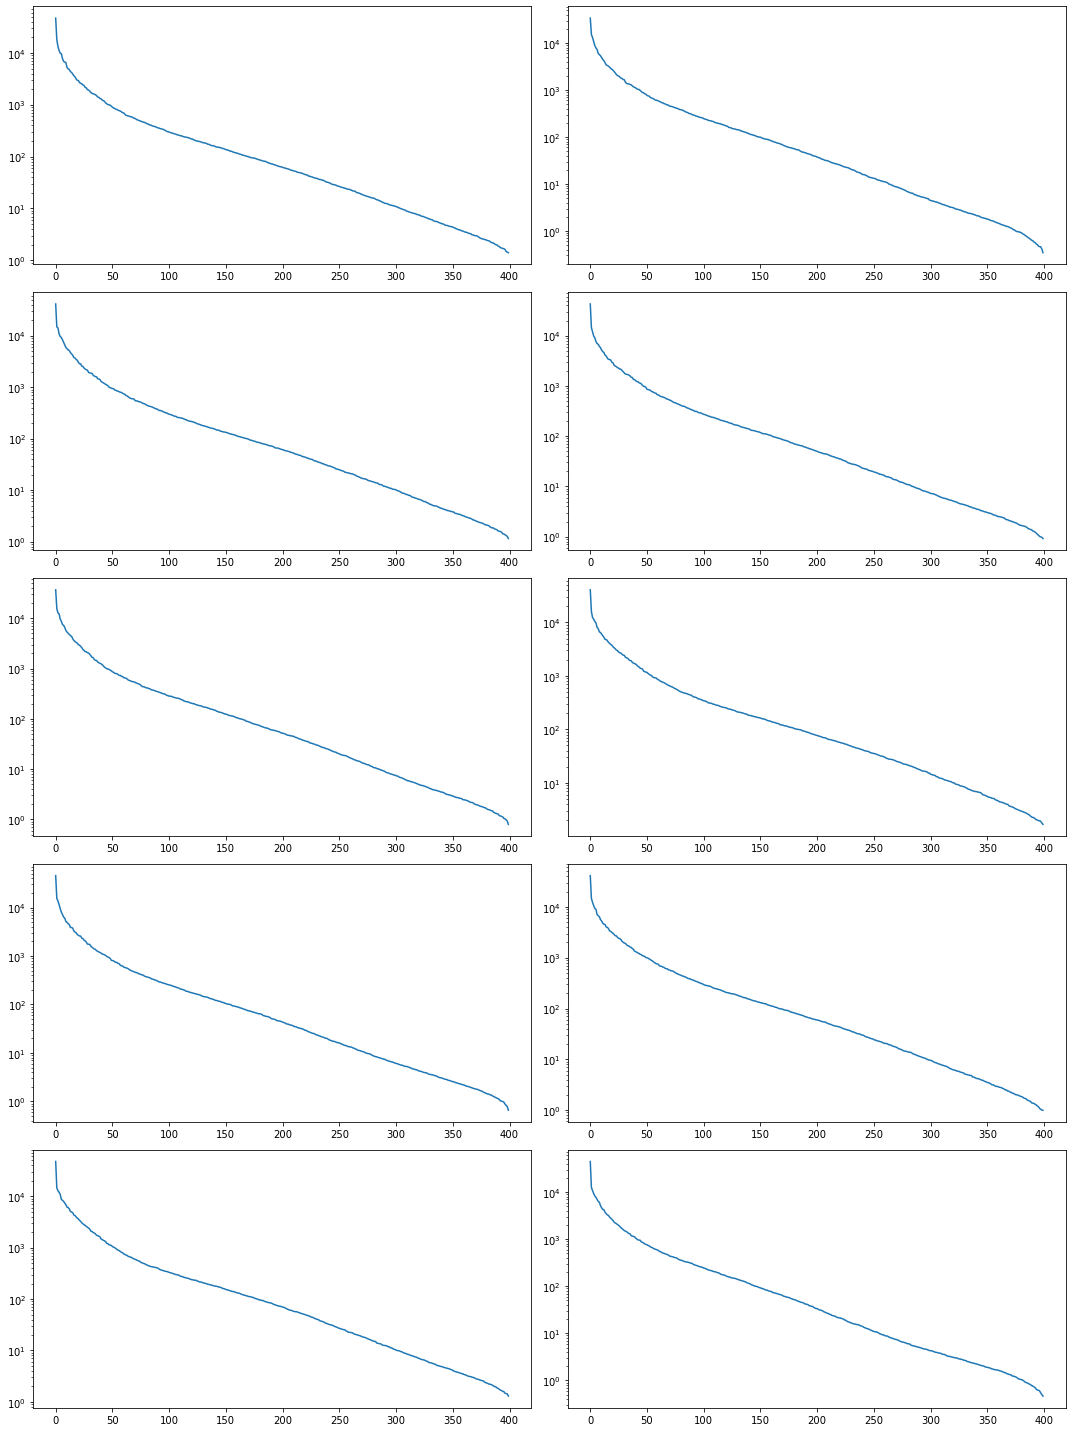

In [22]:
%%time
display(HTML('<h2>Norme odsječaka jezgrenih tenzora u modu 3</h2>'))
core,factors={},{}
m=[]
plt.figure(figsize=(15,20))
for i in range(10):
    A[i]=np.transpose(A[i],axes=[1,2,0])
    first_dim=min(np.shape(A[i])[1]*np.shape(A[i])[2],np.shape(A[i])[0])
    core[i], factors[i] = tucker(A[i],rank=[first_dim,np.shape(A[i])[1],np.shape(A[i])[2]])
    s=[]
    first=1
    for j in range(first_dim):
        s.append(np.linalg.norm(core[i][j,:,:],'fro'))
        if(s[j]<1e-06 and first):
            m.append(j)
            first=0
    if(first==1):
        m.append(first_dim)
        
    plt.subplot(5,2,i+1)
    plt.semilogy(s)
    A[i]=np.transpose(A[i],axes=[2,0,1])
plt.tight_layout()

In [23]:
m

[400, 400, 400, 400, 400, 400, 400, 400, 400, 400]

In [24]:
%%time
S={}
for i in range(10):
    if(m[i]<np.shape(core[i])[0]):
        core[i]=core[i][:m[i],:,:]
        factors[i][0]=factors[i][0][:,:m[i]]
    S[i]=[]
    for j in range(np.shape(core[i])[2]):
        s=tl.tenalg.multi_mode_dot(core[i][:,:,j],matrix_or_vec_list=[factors[i][0],factors[i][1]])
        s=s/np.linalg.norm(s,'fro')
        S[i].append(s)

Wall time: 190 ms


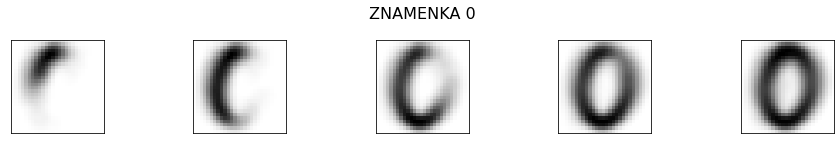

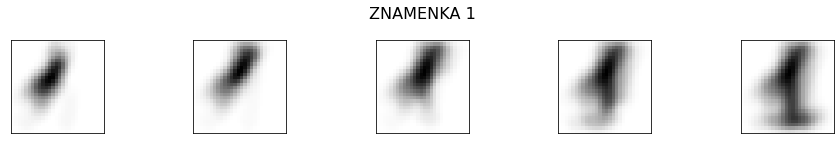

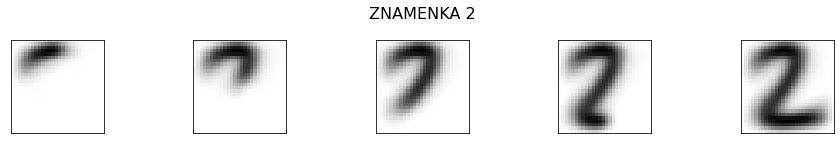

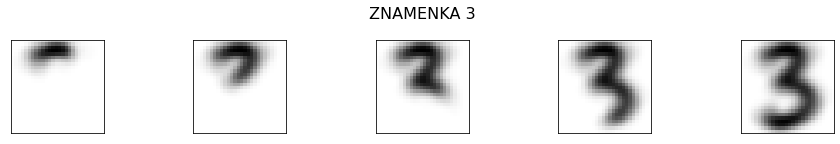

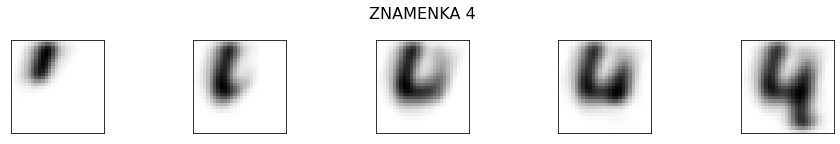

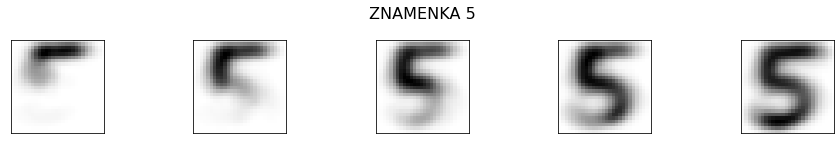

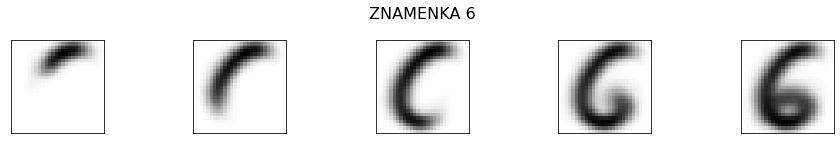

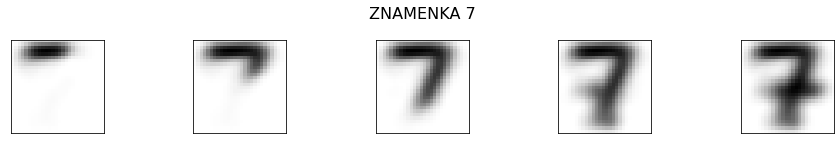

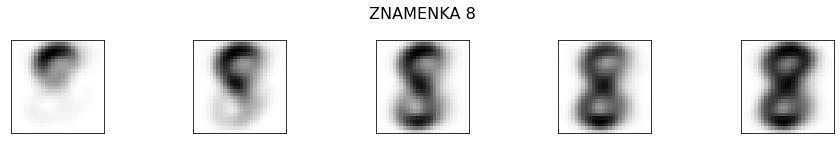

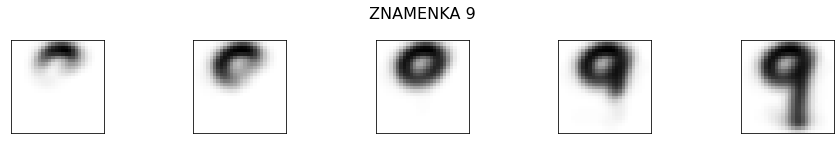

In [25]:
display(HTML('<h2>Komponente tenzorske dekompozicije za svaku znamenku</h2>'))
for j in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(n_frames):
        plt.subplot(1, n_frames, i + 1)
        plt.imshow(S[j][0][:,i].reshape(n,n),cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [26]:
%%time
test_predictions=[]
test_labels=[]
T=defaultdict(list)
for drawing in test:
    test_labels.append(int(drawing.label))
    Z=video_to_tensor(transform_one(drawing,n_frames),base_resolution=base,real_resolution=n,line_width=line_width, 
                      blur_radius=blur_radius)
    Z=Z.astype(np.float64)
    frames_list=[]
    for k in range(n_frames):
        frames_list.append(Z[k].flatten())
    Z=np.stack(frames_list, axis=1)
    Z=Z/np.linalg.norm(Z,'fro')
    R=[]
    for j in range(10):
        E=1-sum((np.trace(S[j][k].T @ Z))**2 for k in range(80))
        R.append(E)
    test_predictions.append(np.argmin(R))
    T[np.argmin(R)].append(Z[:,n_frames-1].reshape(n,n))

Wall time: 8.52 s


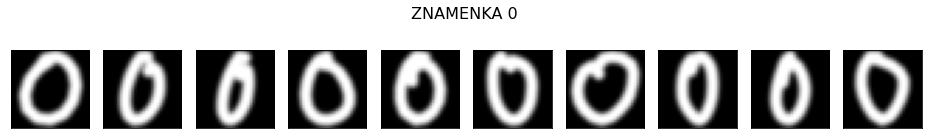

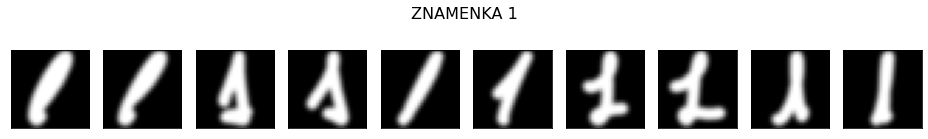

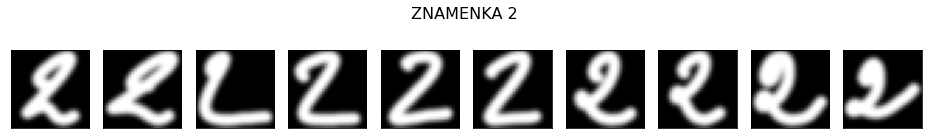

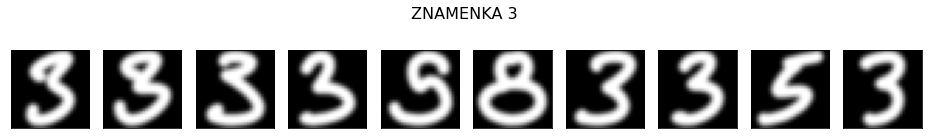

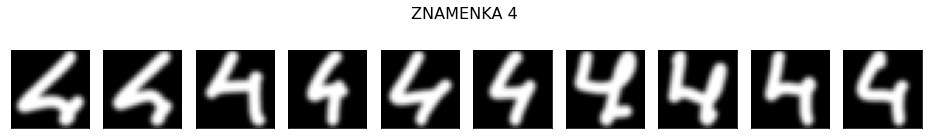

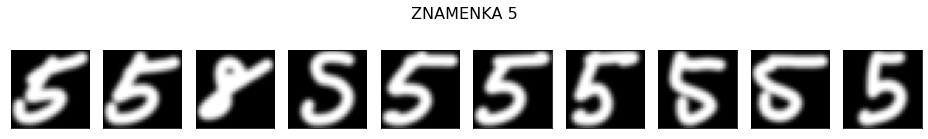

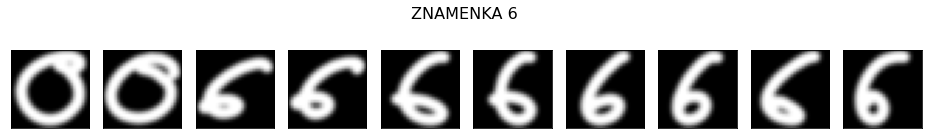

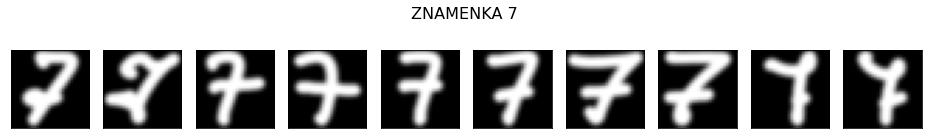

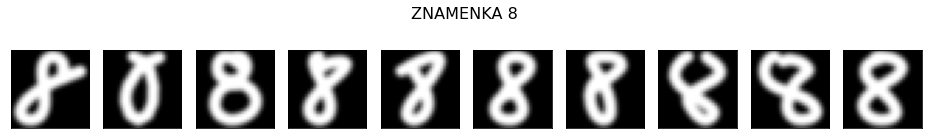

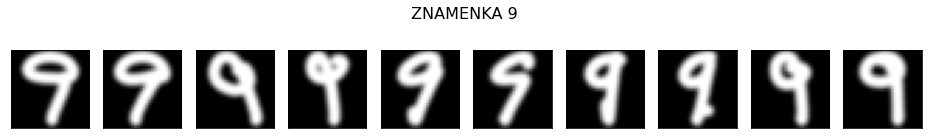

In [27]:
display(HTML('<h2>Predviđene znamenke</h2>'))
for i in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {i}',fontsize=16)
    for j in range(10):
        plt.subplot(1, 10, j + 1)
        plt.imshow(T[i][j],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [28]:
accuracy(test_labels,test_predictions)

Točnost je 96.75 %.


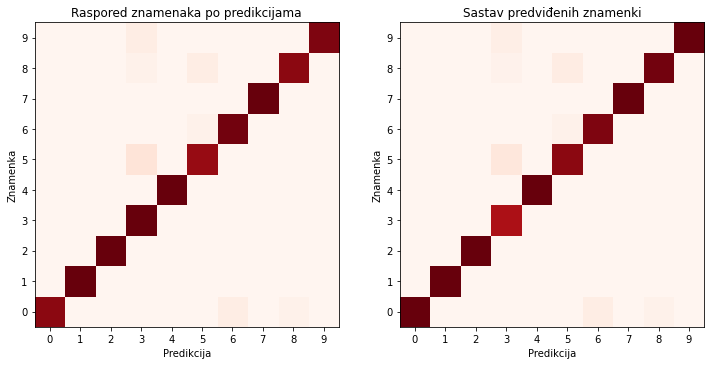

In [29]:
plot_results(pd.Series(test_labels), pd.Series(test_predictions))

# HOSVD za videe preko tenzora framova

In [30]:
n = 20
base=300
n_frames = 5
line_width=40
blur_radius=5

In [31]:
B=defaultdict(list)
for drawing in train:
    tensor=video_to_tensor(transform_one(drawing,n_frames),base_resolution=base,real_resolution=n,line_width=line_width,
                           blur_radius=blur_radius)
    B[int(drawing.label)].append(tensor)

for i in range(10):
    tenzori_framova=[]
    for k in range(n_frames):
        first=True
        for j in range(len(B[i])):
            if first:
                T=B[i][j][k][None]
                first=False
            else:
                T=np.concatenate((T,B[i][j][k][None]),axis=0)
        T=T.astype(np.float64)
        tenzori_framova.append(T)
    B[i]=tenzori_framova

In [32]:
%%time
core,factors=defaultdict(list),defaultdict(list)
m=defaultdict(list)
for i in range(10):
    for k in range(n_frames):
        B[i][k]=np.transpose(B[i][k],axes=[1,2,0])
        c, f= tucker(B[i][k],rank=[np.shape(B[i][k])[0],np.shape(B[i][k])[1],np.shape(B[i][k])[2]])
        core[i].append(c)
        factors[i].append(f)
        s=[]
        first=1
        for j in range(np.shape(B[i][k])[2]):
            s.append(np.linalg.norm(core[i][k][:,:,j],'fro'))
            if(s[j]<1e-06 and first):
                m[i].append(j)
                first=0
        if(first==1):
            m[i].append(np.shape(B[i][k])[2])
            
        B[i][k]=np.transpose(B[i][k],axes=[2,0,1])
    

Wall time: 1.58 s


In [33]:
m

defaultdict(list,
            {0: [80, 80, 80, 80, 80],
             1: [80, 80, 80, 80, 80],
             2: [80, 80, 80, 80, 80],
             3: [80, 80, 80, 80, 80],
             4: [80, 80, 80, 80, 80],
             5: [80, 80, 80, 80, 80],
             6: [80, 80, 80, 80, 80],
             7: [80, 80, 80, 80, 80],
             8: [80, 80, 80, 80, 80],
             9: [80, 80, 80, 80, 80]})

In [34]:
S=defaultdict(list)
for i in range(10):
    for k in range(n_frames):
        temp=[]
        for j in range(np.shape(core[i][k])[2]):
            s=tl.tenalg.multi_mode_dot(core[i][k][:,:,j],matrix_or_vec_list=[factors[i][k][0],factors[i][k][1]])
            s=s/np.linalg.norm(s,'fro')
            temp.append(s)
        S[i].append(temp)

In [35]:
test_predictions=[]
test_labels=[]
for drawing in test:
    test_labels.append(int(drawing.label))
    Z=video_to_tensor(transform_one(drawing,n_frames),base_resolution=300,real_resolution=n,line_width=40)
    Z=Z.astype(np.float64)
    R=[]
    for k in range(n_frames):
        Z_k=Z[k]/np.linalg.norm(Z[k],'fro')
        temp=[]
        for j in range(10):
            E=1-sum((np.trace(S[j][k][l].T @ Z_k))**2 for l in range(80))
            E=E/(n_frames-k)
            temp.append(E)
        R.append(temp)
    
    #temp=R-np.min(R,axis=1)[:,None]
    #temp=np.where(temp==0,1,temp)
    #i=np.argwhere(temp[np.argwhere(temp==np.max(np.min(temp,axis=1)))[0,0]]==1)[0,0]
    #test_predictions.append(i)
    test_predictions.append(np.argmin(np.sum(R,axis=0)))

In [36]:
accuracy(test_labels,test_predictions)

Točnost je 93.25 %.


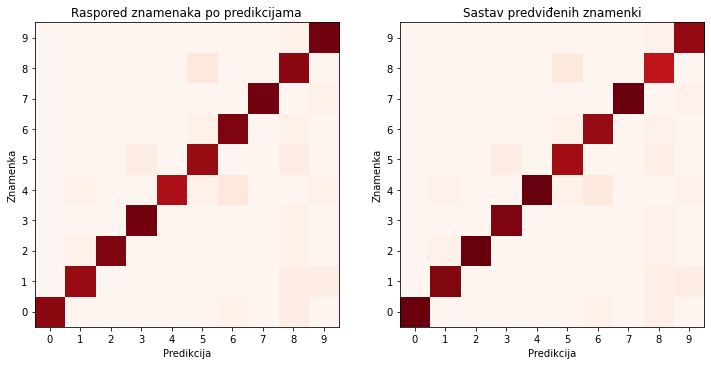

In [37]:
plot_results(pd.Series(test_labels), pd.Series(test_predictions))

# HOSVD za tenzore dimenzije 4

In [38]:
n = 28
base=300
n_frames = 5
line_width=45
blur_radius=8

In [39]:
C=defaultdict(list)
for drawing in train:
    tensor=video_to_tensor(transform_one(drawing,n_frames),base_resolution=base,real_resolution=n,line_width=line_width,
                           blur_radius=blur_radius)
    C[int(drawing.label)].append(tensor)

for i in range(10):
    C[i]=np.stack(C[i], axis=0, out=None)
    C[i]=C[i].astype(np.float64)

In [40]:
np.shape(C[0])

(80, 5, 28, 28)

In [41]:
np.shape(np.transpose(C[0],axes=[2,3,1,0]))

(28, 28, 5, 80)

Wall time: 5.29 s


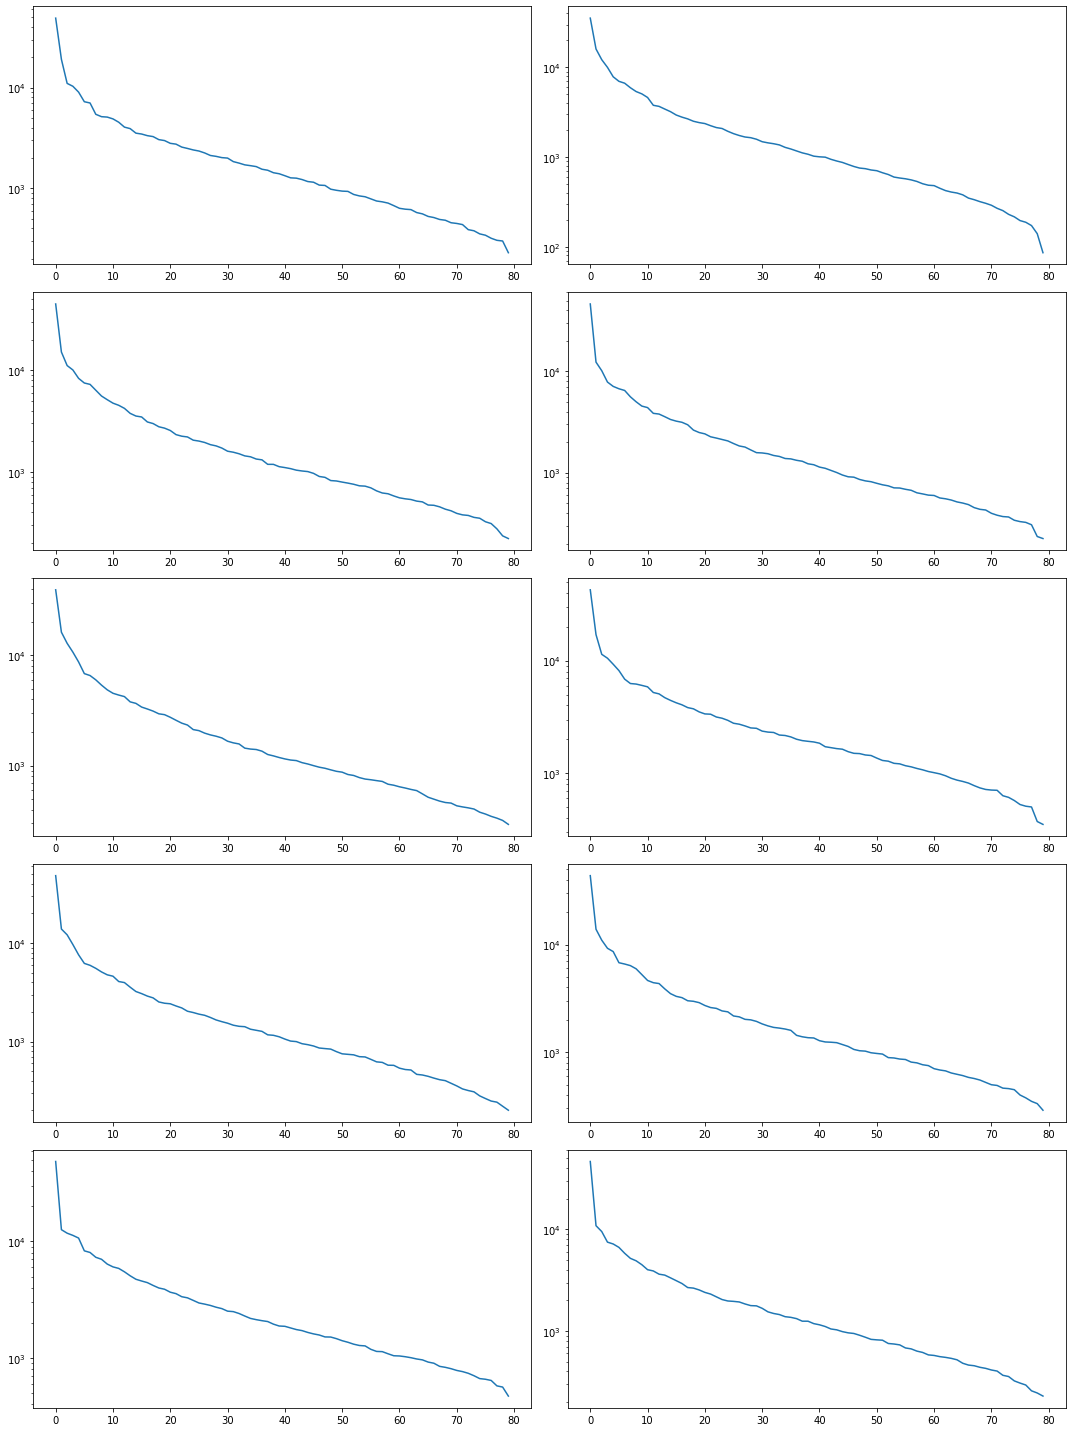

In [42]:
%%time
display(HTML('<h2>Norme odsječaka jezgrenih tenzora u modu 3</h2>'))
core,factors={},{}
m=[]
plt.figure(figsize=(15,20))
for i in range(10):
    C[i]=np.transpose(C[i],axes=[2,3,1,0])
    core[i], factors[i] = tucker(C[i],rank=[np.shape(C[i])[0],np.shape(C[i])[1],np.shape(C[i])[2],np.shape(C[i])[3]])
    s=[]
    first=1
    for j in range(np.shape(C[i])[3]):
        s.append(tl.norm(core[i][:,:,:,j]))
        if(s[j]<1e-06 and first):
            m.append(j)
            first=0
    if(first==1):
        m.append(np.shape(C[i])[3])
        
    plt.subplot(5,2,i+1)
    plt.semilogy(s)
    C[i]=np.transpose(C[i],axes=[3,2,0,1])
plt.tight_layout()

In [43]:
m

[80, 80, 80, 80, 80, 80, 80, 80, 80, 80]

In [44]:
%%time
S={}
for i in range(10):
    if(m[i]<np.shape(core[i])[3]):
        core[i]=core[i][:,:,:,m[i]]
        factors[i][3]=factors[i][3][:,:m[i]]
    S[i]=[]
    for j in range(np.shape(core[i])[3]):
        s=tl.tenalg.multi_mode_dot(core[i][:,:,:,j],matrix_or_vec_list=[factors[i][0],factors[i][1],factors[i][2]])
        s=s/tl.norm(s)
        S[i].append(s)

Wall time: 156 ms


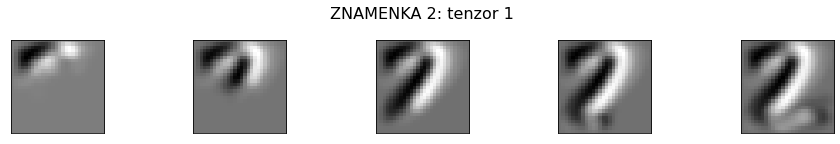

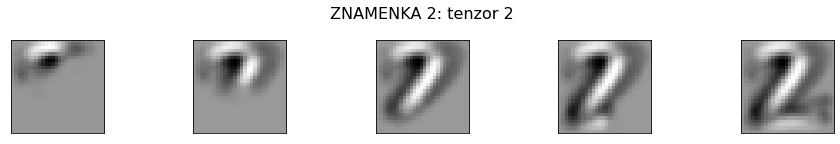

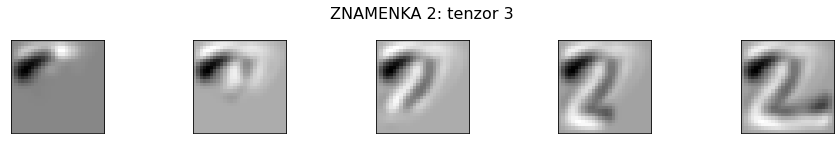

In [45]:
display(HTML('<h2>Komponente tenzorske dekompozicije za znamenku 2</h2>'))
for j in range(3):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA 2: tenzor {j+1}',fontsize=16)
    for i in range(n_frames):
        plt.subplot(1, n_frames, i + 1)
        plt.imshow(S[2][j+1][:,:,i].reshape(n,n),cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [46]:
%%time
test_predictions=[]
test_labels=[]
T=defaultdict(list)
for drawing in test:
    test_labels.append(int(drawing.label))
    Z=video_to_tensor(transform_one(drawing,n_frames),base_resolution=base,real_resolution=n,line_width=line_width, 
                      blur_radius=blur_radius)
    Z=Z.astype(np.float64)
    Z=np.transpose(Z,axes=[1,2,0])
    Z=Z/tl.norm(Z)
    R=[]
    for j in range(10):
        E=1-sum((tl.tenalg.inner(Z,S[j][k]))**2 for k in range(80))
        R.append(E)
    test_predictions.append(np.argmin(R))
    T[np.argmin(R)].append(Z[:,:,n_frames-1])

Wall time: 9.61 s


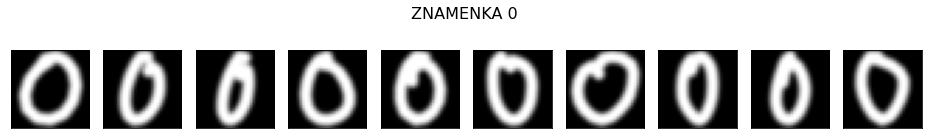

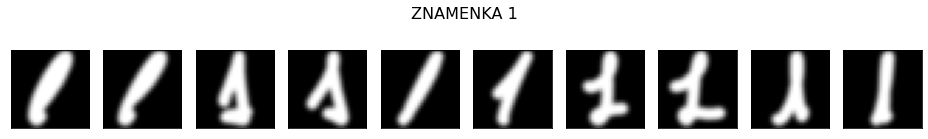

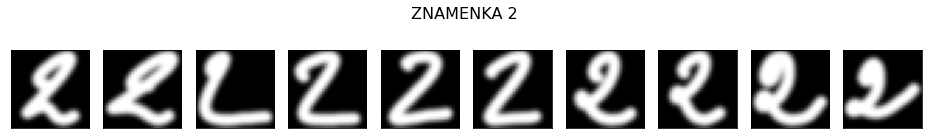

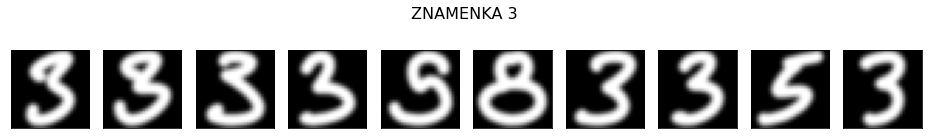

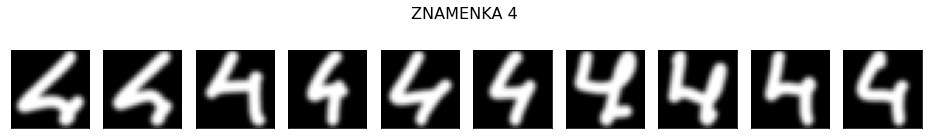

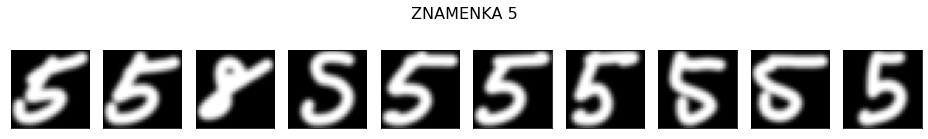

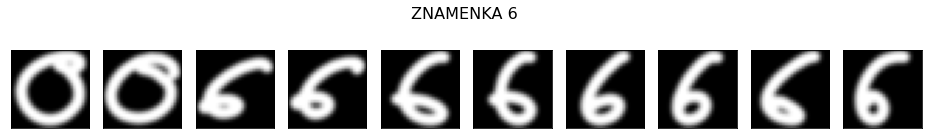

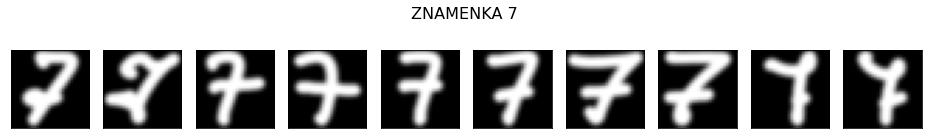

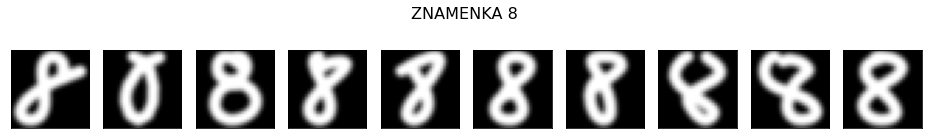

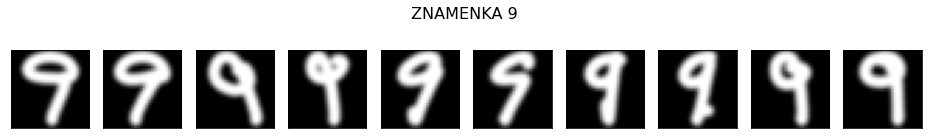

In [47]:
display(HTML('<h2>Predviđene znamenke</h2>'))
for i in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {i}',fontsize=16)
    for j in range(10):
        plt.subplot(1, 10, j + 1)
        plt.imshow(T[i][j],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [48]:
accuracy(test_labels,test_predictions)

Točnost je 96.75 %.


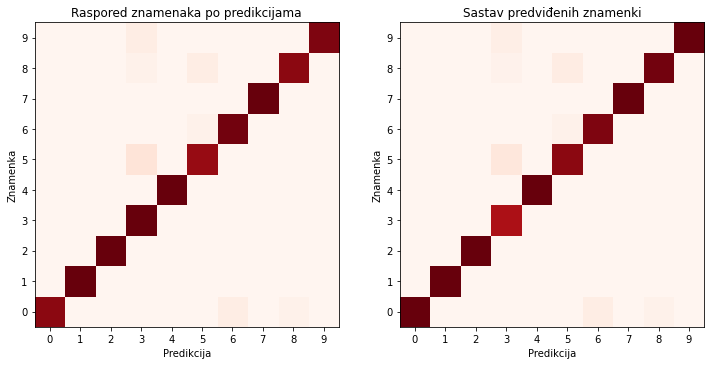

In [49]:
plot_results(pd.Series(test_labels), pd.Series(test_predictions))

# HOSVD koristeći gradijent boja

In [50]:
n = 28
line_width=3
blur_radius=1
precision=2

In [51]:
gradient_creator = GradientCreator(
    gradients = [
        create_gradient([(0, 0), (1, 255)], 100), # bijela -> crna
        create_gradient([(0, 255), (1, 0)], 100), # crna -> bijela
        create_gradient([(0, 0), (0.5, 255), (1, 0)], 100), # bijela -> crna -> bijela
    ],
    clip=(-0.15, 1.15, -0.15, 1.15),
    size=(n, n),
    width=line_width,
    blur_radius=blur_radius,
    precision=precision
)

In [52]:
gradients = gradient_creator.transform(train)
labels = np.array([int(drawing.label) for drawing in train], dtype=np.int8)

In [53]:
np.shape(gradients[0])

(3, 28, 28)

In [54]:
D=defaultdict(list)
A=defaultdict(list)
for i in range(10):
    indeksi=np.where(labels==i)[0]
    D[i]=gradients[indeksi]
    for j in range(len(D[i])):
        frames_list=[]
        for k in range(3):
            frames_list.append(D[i][j][k].flatten())
        A[i].append(np.stack(frames_list, axis=1))
    A[i]=np.stack(A[i], axis=0, out=None)
    A[i]=A[i].astype(np.float64)

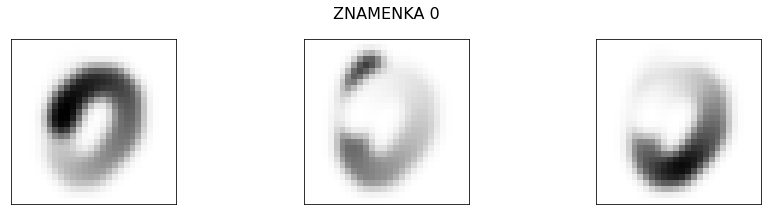

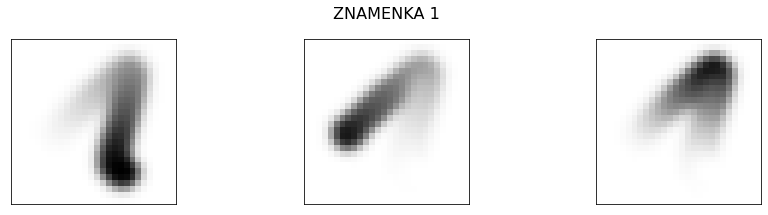

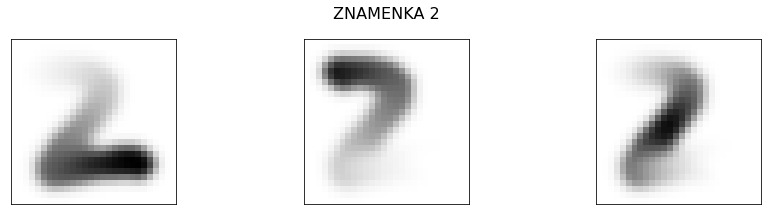

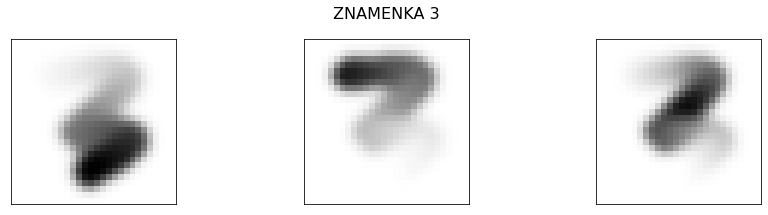

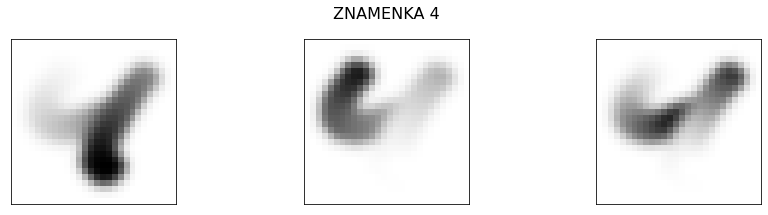

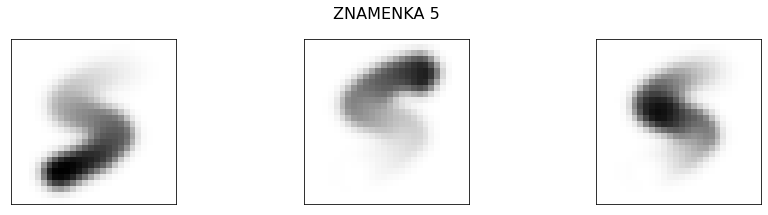

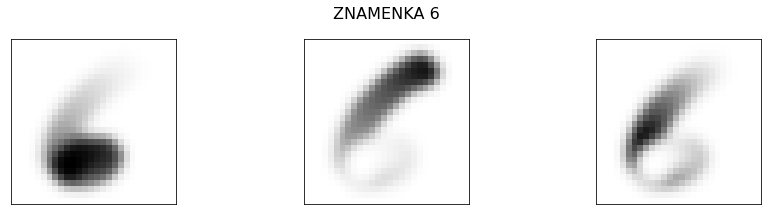

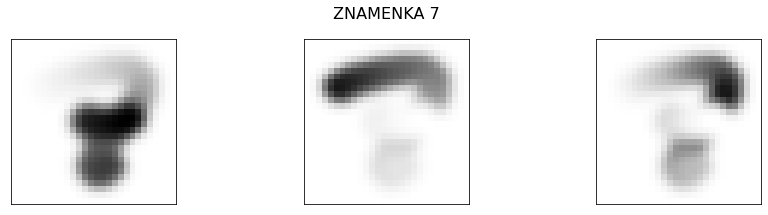

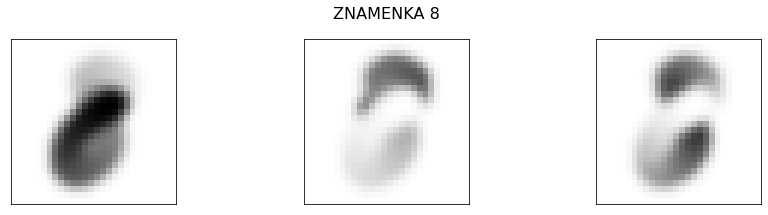

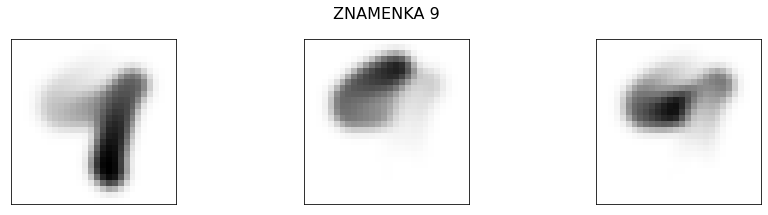

In [55]:
for j in range(10):
    fig=plt.figure(figsize=(13, 3))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(A[j][1,:,i].reshape(n,n), cmap='Greys', vmin=0, vmax=255)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

Wall time: 2.75 s


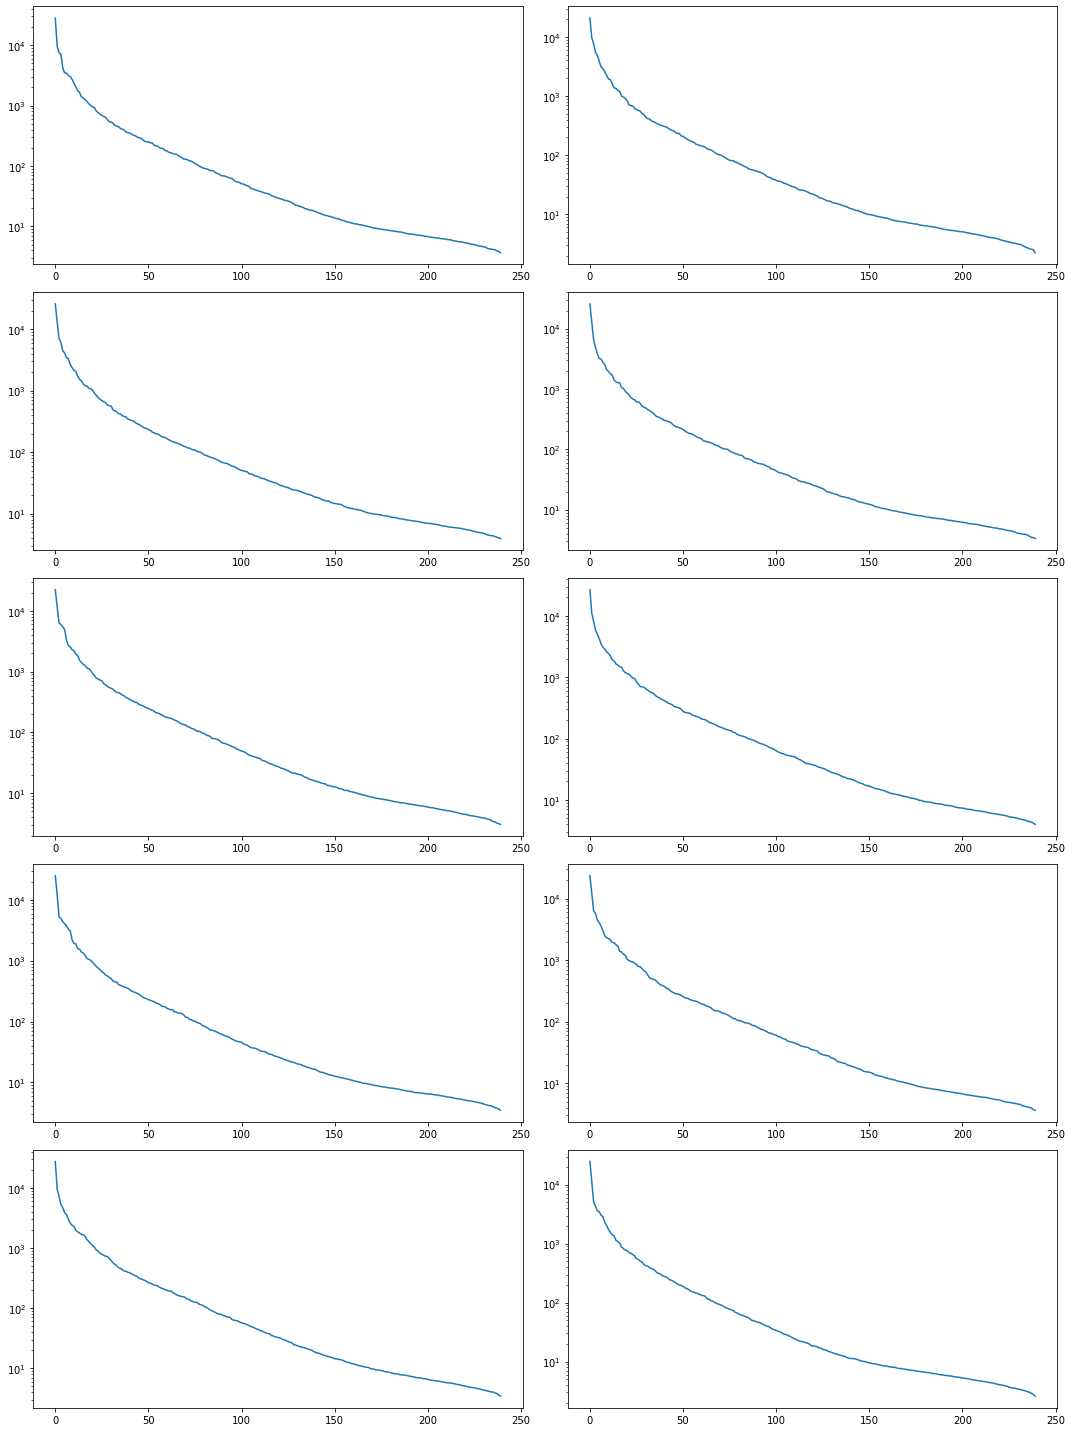

In [56]:
%%time
display(HTML('<h2>Norme odsječaka jezgrenih tenzora u modu 3</h2>'))
core,factors={},{}
m=[]
plt.figure(figsize=(15,20))
for i in range(10):
    A[i]=np.transpose(A[i],axes=[1,2,0])
    first_dim=min(np.shape(A[i])[1]*np.shape(A[i])[2],np.shape(A[i])[0])
    core[i], factors[i] = tucker(A[i],rank=[first_dim,np.shape(A[i])[1],np.shape(A[i])[2]])
    s=[]
    first=1
    for j in range(first_dim):
        s.append(np.linalg.norm(core[i][j,:,:],'fro'))
        if(s[j]<1e-06 and first):
            m.append(j)
            first=0
    if(first==1):
        m.append(first_dim)
        
    plt.subplot(5,2,i+1)
    plt.semilogy(s)
    A[i]=np.transpose(A[i],axes=[2,0,1])
plt.tight_layout()

In [57]:
m

[240, 240, 240, 240, 240, 240, 240, 240, 240, 240]

In [58]:
%%time
S={}
for i in range(10):
    if(m[i]<np.shape(core[i])[0]):
        core[i]=core[i][:m[i],:,:]
        factors[i][0]=factors[i][0][:,:m[i]]
    S[i]=[]
    for j in range(np.shape(core[i])[2]):
        s=tl.tenalg.multi_mode_dot(core[i][:,:,j],matrix_or_vec_list=[factors[i][0],factors[i][1]])
        s=s/np.linalg.norm(s,'fro')
        S[i].append(s)

Wall time: 176 ms


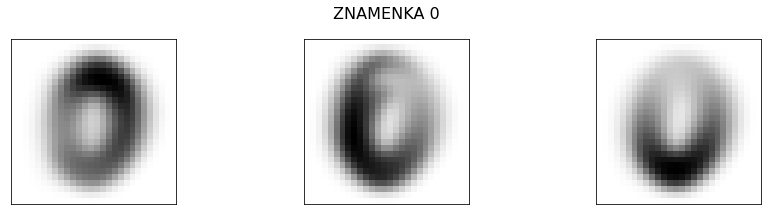

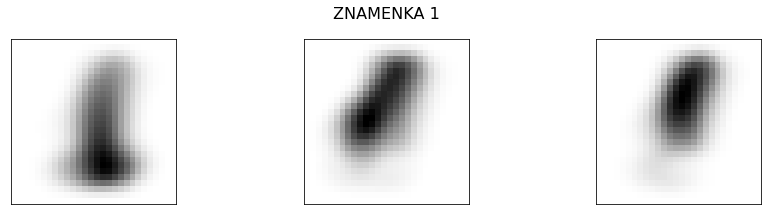

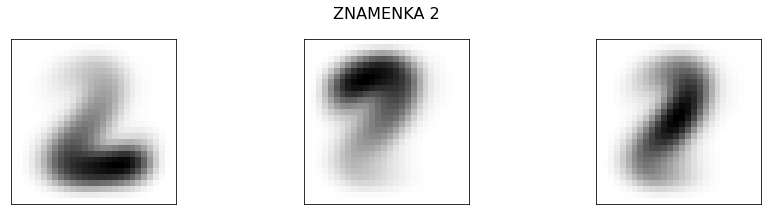

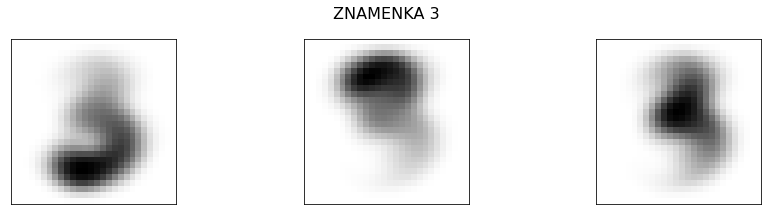

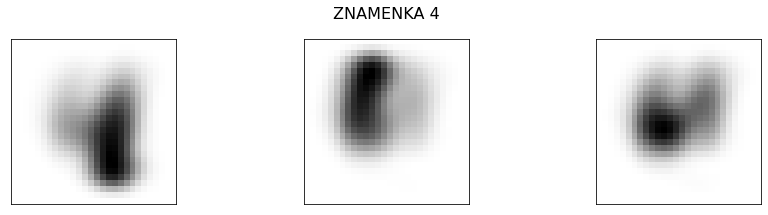

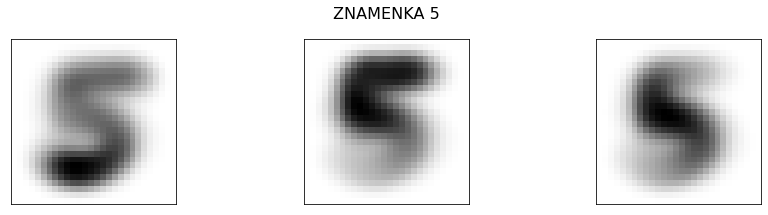

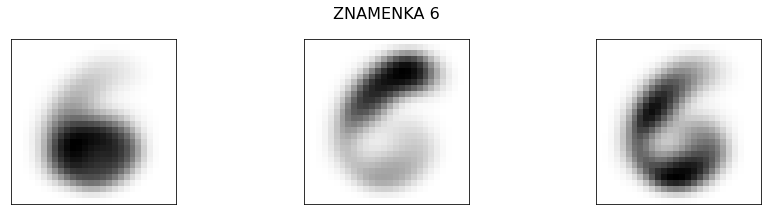

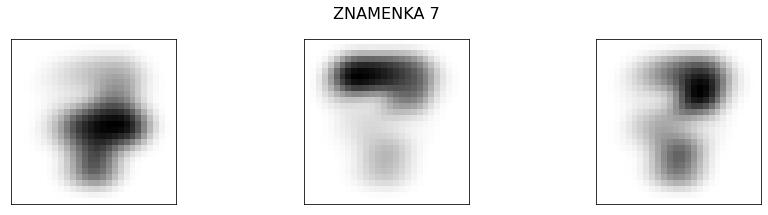

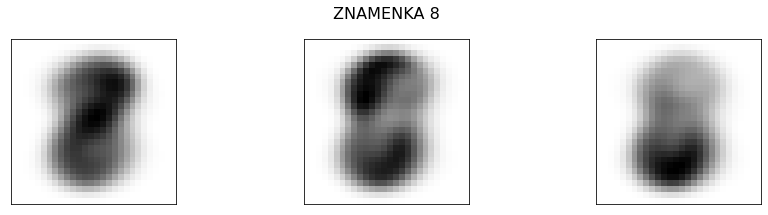

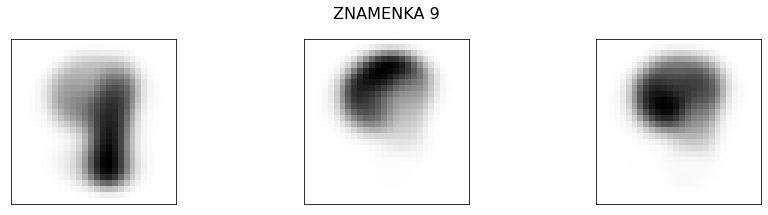

In [59]:
display(HTML('<h2>Komponente tenzorske dekompozicije za svaku znamenku</h2>'))
for j in range(10):
    fig=plt.figure(figsize=(13, 3))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(S[j][0][:,i].reshape(n,n),cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [60]:
%%time
test_predictions=[]
test_labels=[]
for drawing in test:
    test_labels.append(int(drawing.label))
    Z=gradient_creator.transform_one(drawing)
    Z=Z.astype(np.float64)
    frames_list=[]
    for k in range(3):
        frames_list.append(Z[k].flatten())
    Z=np.stack(frames_list, axis=1)
    Z=Z/np.linalg.norm(Z,'fro')
    R=[]
    for j in range(10):
        E=1-sum((tl.tenalg.inner(Z,S[j][k]))**2 for k in range(80))
        R.append(E)
    test_predictions.append(np.argmin(R))

Wall time: 8.47 s


In [61]:
accuracy(test_labels,test_predictions)

Točnost je 97.25 %.


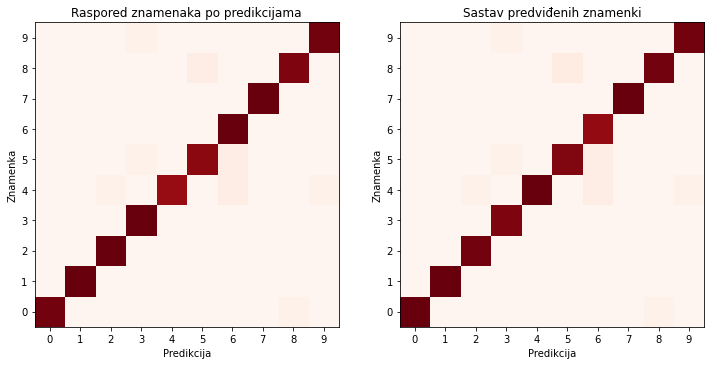

In [62]:
plot_results(pd.Series(test_labels), pd.Series(test_predictions))